In [1]:
import numpy as np
import pandas as pd
import cmath
from scipy.fft import fft, ifft
%matplotlib widget
import matplotlib.pyplot as plt

### Импорт данных

In [2]:
pin_diode = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\27sept\\waveguide\\pin_diode.s1p',
                          sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                          names=['Frequency', 'ReS11', 'ImS11'])
screen = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\27sept\\waveguide\\screen.s1p',
                          sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                          names=['Frequency', 'ReS11', 'ImS11'])
kz = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\27sept\\waveguide\\kz.s1p',
                          sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                          names=['Frequency', 'ReS11', 'ImS11'])
xx_0 = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\27sept\\waveguide\\xx0.s1p',
                          sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                          names=['Frequency', 'ReS11', 'ImS11'])
xx_2 = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\27sept\\waveguide\\xx2.s1p',
                          sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                          names=['Frequency', 'ReS11', 'ImS11'])
xx_8 = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\27sept\\waveguide\\xx8.s1p',
                          sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                          names=['Frequency', 'ReS11', 'ImS11'])
xx_nn = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\27sept\\waveguide\\xx_no_number.s1p',
                          sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                          names=['Frequency', 'ReS11', 'ImS11'])

In [3]:
df_list = [pin_diode, screen, kz, xx_0, xx_2, xx_8, xx_nn]

for df in df_list:
    df['S11'] = df['ReS11'] + 1j*df['ImS11']

del df_list
del df

In [4]:

pin_diode = pin_diode.drop(['ReS11', 'ImS11'], axis=1)
screen = screen.drop(['ReS11', 'ImS11'], axis=1)
kz = kz.drop(['ReS11', 'ImS11'], axis=1)
xx_0 = xx_0.drop(['ReS11', 'ImS11'], axis=1)
xx_2 = xx_2.drop(['ReS11', 'ImS11'], axis=1)
xx_8 = xx_8.drop(['ReS11', 'ImS11'], axis=1)
xx_nn = xx_nn.drop(['ReS11', 'ImS11'], axis=1)

### Time-Gating

In [5]:
time_gating = True

In [6]:
N_fft = 2 ** 22 # количиство точек во временной области
# Должно иметь степень двойки для большей скорости и быть большем, чем количество частотных точек
T_max = 1 / (pin_diode['Frequency'][1]-pin_diode['Frequency'][0]) # продолжительность измеряемого импульса, определяется из количества измеряемых частотных точек
print(T_max)
time = T_max*np.linspace(0, 1 + T_max, N_fft) # набор точек во временной области
print(time[-1]) # последний элемент

5e-07
5.0000025e-07


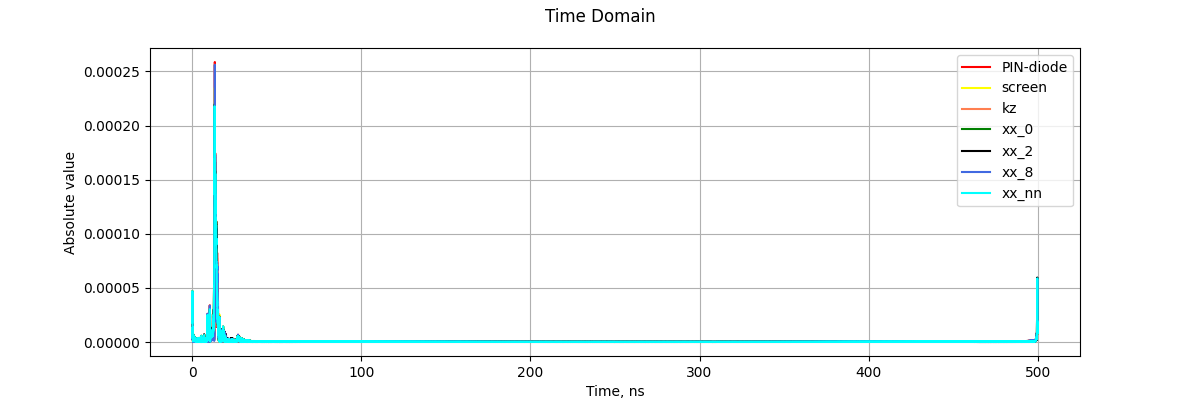

In [7]:
fig3 = plt.figure(figsize=(12,4))

ax_1 = fig3.add_subplot(111)
ax_1.plot(time*1e9, abs(ifft(pin_diode['S11'].to_numpy(), n=N_fft)),'r', label='PIN-diode')
ax_1.plot(time*1e9, abs(ifft(screen['S11'].to_numpy(), n=N_fft)),'yellow', label='screen')
ax_1.plot(time*1e9, abs(ifft(kz['S11'].to_numpy(), n=N_fft)),color='coral', label='kz')
ax_1.plot(time*1e9, abs(ifft(xx_0['S11'].to_numpy(), n=N_fft)),'g', label='xx_0')
ax_1.plot(time*1e9, abs(ifft(xx_2['S11'].to_numpy(), n=N_fft)),'k', label='xx_2')
ax_1.plot(time*1e9, abs(ifft(xx_8['S11'].to_numpy(), n=N_fft)),color='royalblue', label='xx_8')
ax_1.plot(time*1e9, abs(ifft(xx_nn['S11'].to_numpy(), n=N_fft)),'aqua', label='xx_nn')

ax_1.set_xlabel("Time, ns")
ax_1.set_ylabel("Absolute value")
ax_1.legend()
ax_1.grid()


fig3.suptitle('Time Domain')
plt.show()

In [13]:
gate = np.array([[0, 12], [20, 900]])*1e-9 # заполнить промежутками времени, которые необходимо вырезать в нс

In [14]:
def time_gate_s_param(gate: np.ndarray, s_par: pd.core.series.Series, n=N_fft, time=time):
    s = s_par.to_numpy()
    time_dom_s = pd.Series(ifft(s, n=n))
    for k in range(gate.shape[0]):
        if len(gate[k, :]) != 0:
            numbers = (time >= gate[k, 0]) & (time <= gate[k, 1])
            time_dom_s.loc[numbers] = 0
            #print(time_dom_s.head())
    s_new = fft(time_dom_s.to_numpy())
    s_new = s_new[0:len(pin_diode['Frequency'].to_numpy())]
    return pd.Series(s_new)

In [15]:
if time_gating == True:
    pin_diode['S11'] = time_gate_s_param(gate=gate, s_par=pin_diode['S11'])
    screen['S11'] = time_gate_s_param(gate=gate, s_par=screen['S11'])
    kz['S11'] = time_gate_s_param(gate=gate, s_par=kz['S11'])
    xx_0['S11'] = time_gate_s_param(gate=gate, s_par=xx_0['S11'])
    xx_2['S11'] = time_gate_s_param(gate=gate, s_par=xx_2['S11'])
    xx_8['S11'] = time_gate_s_param(gate=gate, s_par=xx_8['S11'])
    xx_nn['S11'] = time_gate_s_param(gate=gate, s_par=xx_nn['S11'])

### Построение графиков

In [16]:
df_list = [pin_diode, kz, xx_0, xx_2, xx_8, xx_nn]

for df in df_list:
    df['S11_norm'] = -df['S11'] / screen['S11']

del df_list
del df

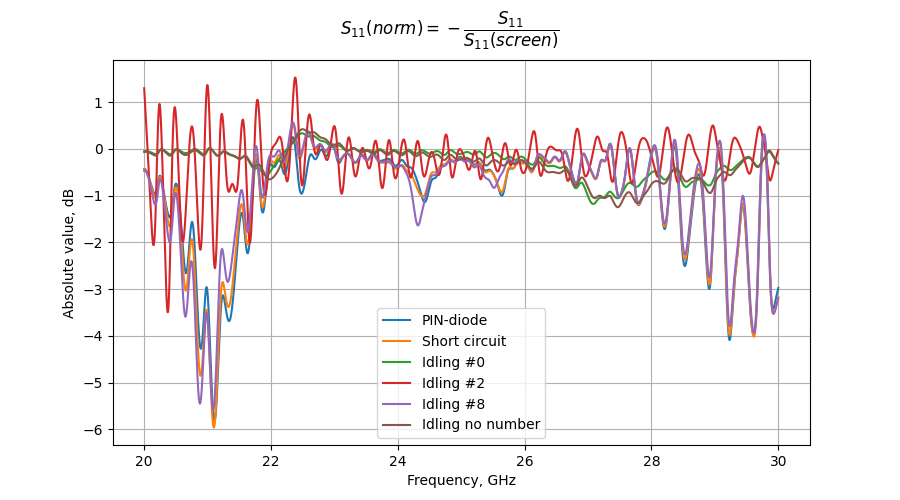

In [17]:
fig1 = plt.figure(figsize=(9,5))

ax_1 = fig1.add_subplot(111)
ax_1.plot(pin_diode['Frequency']*1e-9, 20*np.log10(pin_diode['S11_norm'].apply(abs)), label=r'PIN-diode')
ax_1.plot(kz['Frequency']*1e-9, 20*np.log10(kz['S11_norm'].apply(abs)), label=r'Short circuit')
ax_1.plot(xx_0['Frequency']*1e-9, 20*np.log10(xx_0['S11_norm'].apply(abs)), label=r'Idling #0')
ax_1.plot(xx_2['Frequency']*1e-9, 20*np.log10(xx_2['S11_norm'].apply(abs)), label=r'Idling #2')
ax_1.plot(xx_8['Frequency']*1e-9, 20*np.log10(xx_8['S11_norm'].apply(abs)), label=r'Idling #8')
ax_1.plot(xx_nn['Frequency']*1e-9, 20*np.log10(xx_nn['S11_norm'].apply(abs)), label=r'Idling no number')
ax_1.set_xlabel(r'Frequency, GHz')
ax_1.set_ylabel('Absolute value, dB')
ax_1.legend()
ax_1.grid()


fig1.suptitle(r'$S_{11}(norm) = -\dfrac{S_{11}}{S_{11}(screen)}$')
plt.show()

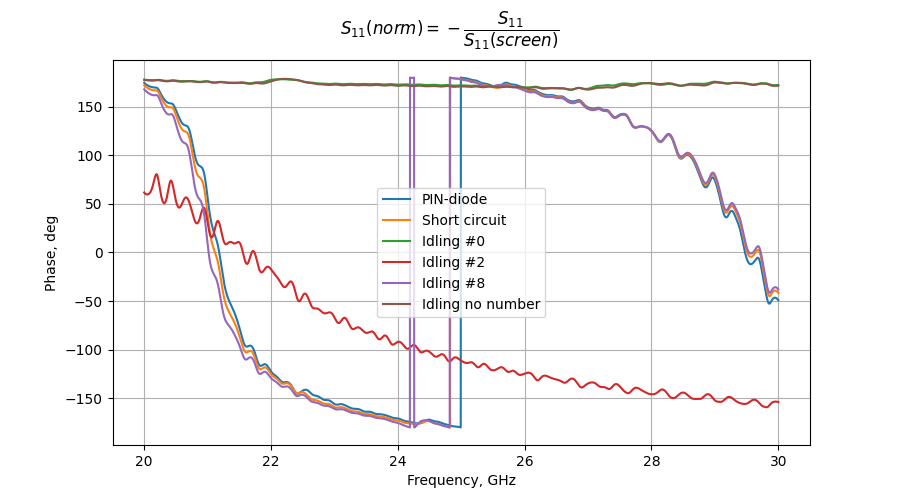

In [18]:
fig2 = plt.figure(figsize=(9,5))

ax_1 = fig2.add_subplot(111)
ax_1.plot(pin_diode['Frequency']*1e-9, np.degrees(pin_diode['S11_norm'].apply(cmath.phase)), label=r'PIN-diode')
ax_1.plot(kz['Frequency']*1e-9, np.degrees(kz['S11_norm'].apply(cmath.phase)), label=r'Short circuit')
ax_1.plot(xx_0['Frequency']*1e-9, np.degrees(xx_0['S11_norm'].apply(cmath.phase)), label=r'Idling #0')
ax_1.plot(xx_2['Frequency']*1e-9, np.degrees(xx_2['S11_norm'].apply(cmath.phase)), label=r'Idling #2')
ax_1.plot(xx_8['Frequency']*1e-9, np.degrees(xx_8['S11_norm'].apply(cmath.phase)), label=r'Idling #8')
ax_1.plot(xx_nn['Frequency']*1e-9, np.degrees(xx_nn['S11_norm'].apply(cmath.phase)), label=r'Idling no number')
ax_1.set_xlabel(r'Frequency, GHz')
ax_1.set_ylabel('Phase, deg')
ax_1.legend()
ax_1.grid()


fig2.suptitle(r'$S_{11}(norm) = -\dfrac{S_{11}}{S_{11}(screen)}$')
plt.show()